In [1]:
%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt

import time
import numpy as np

from SES_setup import *
from utils import *
from style import *

SES_setup loaded globally


In [2]:
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 1.5
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 18
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{physics} ')
colours = ['#1E90FF', '#3CB371', '#FFA500', '#FF0000']

In [3]:
def coherent_overlaps_plain(PARAMS):
    disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    return np.exp(-(disp_1**2)/2), np.exp((-(disp_2**2)/2))

def coherent_overlaps(PARAMS):
    dark_disps, bright_disps = bright_dark_displacements(PARAMS)
    
    return [np.exp(-(alpha**2)/2) for alpha in dark_disps], [np.exp(-(alpha**2)/2) for alpha in bright_disps]

def dark_bright_displacements(PARAMS):
    disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']**2+4*PARAMS['V']**2)
    coeff_m = (eta-PARAMS['bias'])/(2*eta)
    coeff_p = (eta+PARAMS['bias'])/(2*eta)
    
    # dark 1&2, bright 1&2
    return [disp_1*coeff_m, disp_2*coeff_p], [disp_1*coeff_p, disp_2*coeff_m]


def polaron_eigenstates_perturbation(PARAMS):
    dark_disps, bright_disps = dark_bright_displacements(PARAMS)
    energies, states = exciton_states(PARAMS)
    eta = gap(PARAMS['bias'], PARAMS['V'])
    lam_1 = np.sqrt(np.pi * PARAMS['alpha_1'] * PARAMS['w0_1'] / 2.)
    lam_2 = np.sqrt(np.pi * PARAMS['alpha_2'] * PARAMS['w0_2'] / 2.) 
    eps = PARAMS['bias']
    coeff_m = (eta-PARAMS['bias'])/(2*eta)
    coeff_p = (eta+PARAMS['bias'])/(2*eta)
    disp_1p, disp_2p = bright_disps[0], bright_disps[1]
    disp_1m, disp_2m = dark_disps[0], dark_disps[1]
    
    bright_energy = energies[1] + (lam_1**2)*coeff_p/eta
    bright_energy += (lam_2**2)*coeff_m/eta
    
    dark_energy = energies[0]  - (lam_1**2)*coeff_p/eta
    dark_energy += - (lam_2**2)*coeff_p/eta
    
    return [dark_energy, bright_energy] #, [v_m, v_p]


In [4]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0. # 10e-3 * ev_to_inv_cm
V = 5e-3 * ev_to_inv_cm
alpha = 10e-3 * ev_to_inv_cm
T_EM = 6000.
T_ph = 77.
alpha_EM = 5.309e-3
#alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 100. #2*w0
w0 = 30e-3*ev_to_inv_cm
N=5


PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
energies, states = exciton_states(PARAMS, shift=True)
energies_P = polaron_eigenstates_perturbation(PARAMS)
print(energies_P)
print(energies)

No RC mapping performed yet. Using pi*alpha/2
[10871.294766787074, 11712.105233212924]
[11378.065077737641, 11458.72007773764]


In [5]:
def polaron_gap(PARAMS):
    disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    B1 = np.exp(-(disp_1**2)/2)  # Coth(beta_f(PARAMS['T_1'])*PARAMS['w0_1']/2)*
    B2 = np.exp(-(disp_2**2)/2) # Coth(beta_f(PARAMS['T_2'])*PARAMS['w0_2']/2)*
    eta = gap(PARAMS['bias'], PARAMS['V'])
    L = sqrt(PARAMS['bias']**2 + 4*B1*B2*(PARAMS['V']**2))
    #L = sqrt(PARAMS['bias']**2 + 4*B1*B2*(PARAMS_['V']**2))
    eta_polaron = (gap(PARAMS['bias'],  np.sqrt(B1*B2)*PARAMS['V'])**2)/eta
    return B1, B2, L/eta

def polaron_eigenstates(PARAMS_):
    B1, B2, eta_polaron = polaron_gap(PARAMS)
    w_1, w_2 = PARAMS_['w_1'], PARAMS_['w_1']
    shift_1, shift_2 = 0,0 #pi*PARAMS['alpha_1']/2, pi*PARAMS['alpha_2']/2
    V = PARAMS_['V']
    bias = PARAMS_['bias']
    
    av_site_energy = (w_1+w_2)/2
    
    second_order = ((2*V*bias*B1*B2/eta)**2)/eta
    #print(second_order)
    dark_energy = av_site_energy - eta_polaron/2 #- second_order
    #dark_energy += PARAMS['w0_1']*(disp_dark[0]**2)+PARAMS['w0_2']*(disp_dark[1]**2)
    
    bright_energy = av_site_energy + eta_polaron/2 #+ second_order
    #bright_energy += PARAMS['w0_1']*(disp_bright[0]**2)+(PARAMS['w0_2']**2)*(disp_bright[1]**2)
    eta_P = eta_polaron
    v_p = qt.Qobj(np.array([0., np.sqrt(eta_P+bias), np.sqrt(eta_P-bias)]))/np.sqrt(2*eta_P)
    v_m = qt.Qobj(np.array([0., np.sqrt(eta_P-bias), -np.sqrt(eta_P+bias)]))/np.sqrt(2*eta_P)
    
    return [dark_energy, bright_energy], [v_m, v_p], eta_polaron


def polaron_eigenstates_(PARAMS_):
    disp_1 = sqrt(pi*PARAMS_['alpha_1']/(2*PARAMS_['w0_1']))
    kappa_1 =  np.sqrt(np.pi * PARAMS_['alpha_1'] * PARAMS_['w0_1'] / 2.)
    disp_2 = sqrt(pi*PARAMS_['alpha_2']/(2*PARAMS_['w0_2']))
    kappa_2 =  np.sqrt(np.pi * PARAMS_['alpha_2'] * PARAMS_['w0_2'] / 2.)
    B1 = np.exp(-(disp_1**2)/2)  # Coth(beta_f(PARAMS['T_1'])*PARAMS['w0_1']/2)*
    B2 = np.exp(-(disp_2**2)/2) # Coth(beta_f(PARAMS['T_2'])*PARAMS['w0_2']/2)*
    #B1, B2 = coherent_overlaps_plain(PARAMS)
    
    w_1, w_2 = PARAMS_['w_1'], PARAMS_['w_1']
    shift_1, shift_2 = 0,0 #pi*PARAMS['alpha_1']/2, pi*PARAMS['alpha_2']/2
    V = PARAMS_['V']
    bias = PARAMS_['bias'] + shift_1 - shift_2
    eta = sqrt(PARAMS_['bias']**2+4*PARAMS_['V']**2)
    av_site_energy = (w_1+shift_1+w_2+shift_2)/2
    
    eta_polaron = sqrt(PARAMS_['bias']**2+4*B1*B2*(PARAMS_['V']**2))
    disp_dark, disp_bright = dark_bright_displacements(PARAMS_)
    second_order = ((2*V*bias*B1*B2/eta)**2)/eta
    #print(second_order)
    dark_energy = av_site_energy - (eta_polaron**2)/(2*eta) #- second_order
    #dark_energy += PARAMS['w0_1']*(disp_dark[0]**2)+PARAMS['w0_2']*(disp_dark[1]**2)
    
    bright_energy = av_site_energy + (eta_polaron**2)/(2*eta) #+ second_order
    #bright_energy += PARAMS['w0_1']*(disp_bright[0]**2)+(PARAMS['w0_2']**2)*(disp_bright[1]**2)
    eta_P = (eta_polaron**2)/eta
    v_p = qt.Qobj(np.array([0., np.sqrt(eta_P+bias), np.sqrt(eta_P-bias)]))/np.sqrt(2*eta_P)
    v_m = qt.Qobj(np.array([0., np.sqrt(eta_P-bias), -np.sqrt(eta_P+bias)]))/np.sqrt(2*eta_P)
    
    return [dark_energy, bright_energy], [v_m, v_p], eta_polaron

In [109]:
"""w_2 = 1.4 * ev_to_inv_cm
bias = 0. # 10e-3 * ev_to_inv_cm
V = 5e-3 * ev_to_inv_cm
alpha = 100e-3 * ev_to_inv_cm
T_EM = 6000.
T_ph = 77.
alpha_EM = 5.309e-3
#alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 100. #2*w0
w0 = 30e-3*ev_to_inv_cm
N=5"""

N=6
T_ph = 100.
w_2 = 1.4*ev_to_inv_cm
bias = 0 #10e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
energies, states = exciton_states(PARAMS, shift=True)
energies_P, states_P, eta_p = polaron_eigenstates(PARAMS)
print (energies, energies_P)
print (PARAMS['V']**2, eta, PARAMS['w0_1'])
print((PARAMS['V']**2 - PARAMS['w0_1']*eta)/(V**2))

No RC mapping performed yet. Using pi*alpha/2
[11212.615796326792, 11373.925796326794] [11211.566902889528, 11371.83309711047]
6505.229025000001 80.655 241.965
-2.0


"        \nplt.figure()\nplt.plot(couplings, Eb_num, label='numerical bright')\nplt.plot(couplings, Eb_an)\nplt.legend()\nplt.figure()\nplt.plot(couplings, np.array(Eb_num)-np.array(Ed_num), label='numerical')\nplt.plot(couplings, np.array(Eb_an)-np.array(Ed_an))\nplt.legend()"

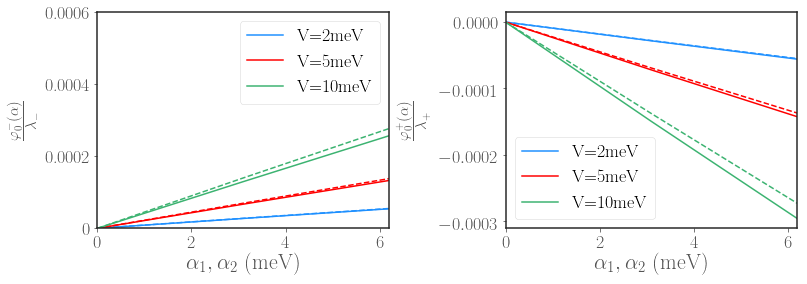

In [103]:
from matplotlib.ticker import FormatStrFormatter
couplings = np.linspace(0.0,50,3)
i =0
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
for V in np.array([2, 5, 10])*1e-3*ev_to_inv_cm:
    Ed_num, Eb_num = [], []
    Ed_an, Eb_an = [], []
    
    for alpha in couplings:
        PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                          silent=True, exc_diff=0)
        H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
        energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
        energies_P, states_P, eta_P = polaron_eigenstates(PARAMS)
        energies, states = exciton_states(PARAMS)
        dark_energy, dark_state = dark_polaron_zeroth(PARAMS)
        Ed_num.append((energies_dict['dark'][0]-energies[0])/energies[0])
        Eb_num.append((energies_dict['bright'][0]-energies[1])/energies[1])
        Ed_an.append((energies_P[0]-energies[0])/energies[0]) # energies_P[0]
        Eb_an.append((energies_P[1]-energies[1])/energies[1])
        #plt.figure()
    ax1.plot(1000*couplings/ev_to_inv_cm, Ed_num, label='V={}meV'.format(int(1000*V/ev_to_inv_cm)), linestyle='solid', color=colours[i])
    ax1.plot(1000*couplings/ev_to_inv_cm, Ed_an, linestyle='dashed', color=colours[i])
    ax2.plot(1000*couplings/ev_to_inv_cm, Eb_num, label='V={}meV'.format(int(1000*V/ev_to_inv_cm)), linestyle='solid', color=colours[i])
    ax2.plot(1000*couplings/ev_to_inv_cm, Eb_an, linestyle='dashed', color=colours[i])
    i+=1
ax1.legend()
ax1.set_ylabel(r"$\frac{\varphi_0^{-}(\alpha)}{\lambda_-}$")
ax1.set_xlim(1000*couplings[0]/ev_to_inv_cm, 1000*couplings[-1]/ev_to_inv_cm)
ax1.set_ylim(0, .0006)
ax1.set_xlabel(r"$\alpha_1, \alpha_2$ (meV)")
ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
ax1.yaxis.set_ticks(np.arange(0, .0008, 0.0002))

ax2.legend()
ax2.set_ylabel(r"$\frac{\varphi_0^{+}(\alpha)}{\lambda_+}$")
ax2.set_xlabel(r"$\alpha_1, \alpha_2$ (meV)")
ax2.set_xlim(1000*couplings[0]/ev_to_inv_cm, 1000*couplings[-1]/ev_to_inv_cm)
plt.subplots_adjust(left=0.14, bottom=0.2, right=0.95, top=0.95, wspace=0.4, hspace=0.08)
#plt.savefig("PLOTS/PAPER/AnalyticEnergies.pdf")
"""        
plt.figure()
plt.plot(couplings, Eb_num, label='numerical bright')
plt.plot(couplings, Eb_an)
plt.legend()
plt.figure()
plt.plot(couplings, np.array(Eb_num)-np.array(Ed_num), label='numerical')
plt.plot(couplings, np.array(Eb_an)-np.array(Ed_an))
plt.legend()"""

Text(0.5,0,'$\\alpha_1, \\alpha_2$ (meV)')

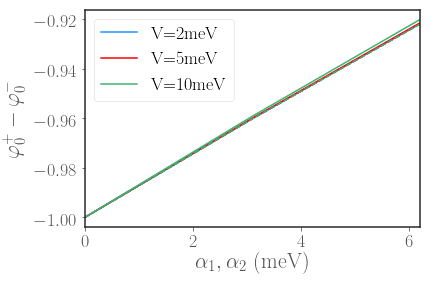

In [84]:
couplings = np.linspace(0.0,50,3)
i =0
fig, ax1 = plt.subplots()
for V in np.array([2, 5, 10])*1e-3*ev_to_inv_cm:
    Ed_num, Eb_num = [], []
    Ed_an, Eb_an = [], []
    
    for alpha in couplings:
        PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                          silent=True, exc_diff=0)
        H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
        energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
        energies_P, states_P, eta_P = polaron_eigenstates(PARAMS)
        energies, states = exciton_states(PARAMS)
        dark_energy, dark_state = dark_polaron_zeroth(PARAMS)
        Ed_num.append(energies_dict['dark'][0])
        Eb_num.append(energies_dict['bright'][0])
        Ed_an.append(energies_P[0]) # energies_P[0]
        Eb_an.append(energies_P[1])
        #plt.figure()
    normed_num = np.abs(np.array(Ed_num)-np.array(Eb_num))/(np.array(Ed_num[0])-np.array(Eb_num[0]))
    normed_an = np.abs(np.array(Ed_an)-np.array(Eb_an))/(np.array(Ed_an[0])-np.array(Eb_an[0]))
    ax1.plot(1000*couplings/ev_to_inv_cm, normed_num, 
             label='V={}meV'.format(int(1000*V/ev_to_inv_cm)), linestyle='solid', color=colours[i])
    ax1.plot(1000*couplings/ev_to_inv_cm, normed_an, 
             linestyle='dashed', color=colours[i])
    i+=1
ax1.legend()
ax1.set_ylabel(r"$\varphi_0^{+}-\varphi_0^{-}$")
ax1.set_xlim(1000*couplings[0]/ev_to_inv_cm, 1000*couplings[-1]/ev_to_inv_cm)
#ax1.set_ylim(0, .0006)
ax1.set_xlabel(r"$\alpha_1, \alpha_2$ (meV)")
#ax1.yaxis.set_major_formatter(FormatStrFormatter('%g'))
#ax1.yaxis.set_ticks(np.arange(0, .0008, 0.0002))

In [82]:
def dark_polaron_zeroth(PARAMS_):
    # For a degenerate system
    disp_1 = sqrt(pi*PARAMS_['alpha_1']/(2*PARAMS_['w0_1']))
    kappa_1 =  np.sqrt(np.pi * PARAMS_['alpha_1'] * PARAMS_['w0_1'] / 2.)
    disp_2 = sqrt(pi*PARAMS_['alpha_2']/(2*PARAMS_['w0_2']))
    kappa_2 =  np.sqrt(np.pi * PARAMS_['alpha_2'] * PARAMS_['w0_2'] / 2.)
    B1 = np.exp(-(disp_1**2)/2)  # Coth(beta_f(PARAMS['T_1'])*PARAMS['w0_1']/2)*
    B2 = np.exp(-(disp_2**2)/2) # Coth(beta_f(PARAMS['T_2'])*PARAMS['w0_2']/2)*
    #B1, B2 = coherent_overlaps_plain(PARAMS)
    
    w_1, w_2 = PARAMS_['w_1'], PARAMS_['w_1']
    shift_1, shift_2 = 0,0 #pi*PARAMS['alpha_1']/2, pi*PARAMS['alpha_2']/2
    V = PARAMS_['V']
    bias = PARAMS_['bias'] + shift_1 - shift_2
    eta = sqrt(PARAMS_['bias']**2+4*PARAMS_['V']**2)
    #av_site_energy = (w_1+w_2)/2
    
    #eta_polaron = sqrt(PARAMS_['bias']**2+4*B1*B2*(PARAMS_['V']**2))
    #disp_dark, disp_bright = dark_bright_displacements(PARAMS_)
    #second_order = ((2*V*bias*B1*B2/eta)**2)/eta
    #print(second_order)
    E_0 = PARAMS_['w_2'] - V*sqrt(B1*B2)
    normy = sqrt((4*E_0**2)/(V**2*(B1*B2)**2+(4*E_0**2)))
    fac = (B1*B2*V)/(2*E_0)
    dark_energy = normy*(PARAMS_['w_1']*fac + PARAMS_['w_2'] + 2*PARAMS_['V']*fac*(B1*B2))
    dark_state = (fac*XO + OX)*normy
    return dark_energy, dark_state

Pretty good qualitative agreement for weak enough V

In [6]:
def rate_up_redfield(w, PARAMS):
    n = Occupation(w, PARAMS['T_1'])
    return 0.5 * pi * n * J_underdamped(w, PARAMS['alpha_1'], 
                           PARAMS['w0_1'], Gamma=PARAMS['Gamma_1']) 

def rate_down_redfield(w,  PARAMS):
    n = Occupation(w, PARAMS['T_1'])
    return 0.5 * pi * (n + 1. ) * J_underdamped(w, PARAMS['alpha_1'], 
                                   PARAMS['w0_1'], Gamma=PARAMS['Gamma_1']) 


def rate_up(w, T, gamma_):
    n = Occupation(w, T)
    rate = 0.5 * pi * n * gamma_ * w
    return rate

def rate_down(w, T, gamma_):
    n = Occupation(w, T)
    rate = 0.5 * pi * (n + 1. ) * gamma_ * w
    return rate


def rate_full(energies_dict, states_dict, A, higher, lower, coupling, T):
    initial_state = states_dict[lower][0]
    initial_energy = energies_dict[lower][0]
    
    r_up = 0
    
    for final_energy, final_state in zip(energies_dict[higher], states_dict[higher]):
        overlap = abs((final_state.dag()*A*initial_state).tr())**2
        r_up += overlap*rate_up(abs(final_energy-initial_energy), T, coupling)
    # Now start from higher state and decay down to manifold
    initial_state = states_dict[higher][0]
    initial_energy = energies_dict[higher][0]
    r_down = 0
    for final_energy, final_state in zip(energies_dict[lower], states_dict[lower]):
        overlap = abs((final_state.dag()*A*initial_state).tr())**2
        r_down += overlap*rate_down(abs(final_energy-initial_energy), T, coupling)
    return r_up, r_down

def rate_flat(energies_dict, states_dict, A, PARAMS, higher, lower):
    initial_state = states_dict[lower][0]
    initial_energy = energies_dict[lower][0]
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    r_up = 0
    
    for final_energy, final_state in zip(energies_dict[higher], states_dict[higher]):
        overlap = abs((final_state.dag()*A*initial_state).tr())**2
        r_up += overlap*rate_up(abs(energies_dict[higher][0]-initial_energy), PARAMS['T_EM'], EM_coupling)
    # Now start from higher state and decay down to manifold
    initial_state = states_dict[higher][0]
    initial_energy = energies_dict[higher][0]
    r_down = 0
    for final_energy, final_state in zip(energies_dict[lower], states_dict[lower]):
        overlap = abs((final_state.dag()*A*initial_state).tr())**2
        r_down += overlap*rate_down(abs(energies_dict[lower][0]-initial_energy), PARAMS['T_EM'], EM_coupling)
    return r_up, r_down

def laser_rates_numerical(PARAMS):
    sigma = sigma_m1 + PARAMS['mu']*sigma_m2 
    H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
    
    I = enr_identity([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    A_EM = tensor(sigma+sigma.dag(), I)
    vacuum  = qt.enr_fock([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], [0,0])
    ground_ansatz = states_dict['ground'][0]
    bright_ansatz = states_dict['bright'][0]
    dark_ansatz = states_dict['dark'][0]
    bright_energy = energies_dict['bright'][0]
    dark_energy = energies_dict['dark'][0]
    
    #H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
    #print((dark_ansatz.dag()*tensor(OX_proj, I)*dark_ansatz).tr())
    optical_coeff_B = abs((bright_ansatz.dag()*A_EM*ground_ansatz).tr())**2
    optical_coeff_D = abs((dark_ansatz.dag()*A_EM*ground_ansatz).tr() )**2 #optical_coeff_B*0.005 #
    #phonon_coeff_1 = abs((bright_ansatz.dag()*tensor(XO_proj, I)*dark_ansatz).tr())
    #phonon_coeff_2 = abs((bright_ansatz.dag()*tensor(OX_proj, I)*dark_ansatz).tr())
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    #print(optical_coeff_B, optical_coeff_D)
    #optical_coeff_B = sqrt(eta_polaron + PARAMS['bias']) + PARAMS['mu']*sqrt(eta_polaron - PARAMS['bias'])
    #optical_coeff_D = sqrt(eta_polaron + PARAMS['bias']) + PARAMS['mu']*sqrt(eta_polaron - PARAMS['bias'])
    eig_difference = bright_energy - dark_energy
    bright_up = optical_coeff_B*rate_up(bright_energy, PARAMS['T_EM'], EM_coupling)
    bright_down = optical_coeff_B*rate_down(bright_energy, PARAMS['T_EM'], EM_coupling)
    
    dark_up = optical_coeff_D*rate_up(dark_energy, PARAMS['T_EM'], EM_coupling)
    dark_down = optical_coeff_D*rate_down(dark_energy, PARAMS['T_EM'], EM_coupling)
    phonon_coeff_1 = 1
    phonon_up = phonon_coeff_1*rate_up(eig_difference, PARAMS['T_1'], PARAMS['gamma_1'])
    #phonon_up += phonon_coeff_2*rate_up(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    
    phonon_down = phonon_coeff_1*rate_down(eig_difference, PARAMS['T_1'], PARAMS['gamma_1'])
    #phonon_down += phonon_coeff_2*rate_down(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    
    return bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down

def laser_rates(PARAMS):
    sigma = sigma_m1 + PARAMS['mu']*sigma_m2 
    energies_P, states_P, eta_polaron = polaron_eigenstates(PARAMS)
    I = enr_identity([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    A_EM = tensor(sigma+sigma.dag(), I)
    vacuum  = qt.enr_fock([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], [0,0])
    ground_ansatz = tensor(OO, vacuum)
    bright_ansatz = tensor(states_P[1], vacuum)
    dark_ansatz = tensor(states_P[0], vacuum)
    #H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
    #print((dark_ansatz.dag()*tensor(OX_proj, I)*dark_ansatz).tr())
    optical_coeff_B = abs((bright_ansatz.dag()*A_EM*ground_ansatz).tr())**2
    optical_coeff_D = abs((dark_ansatz.dag()*A_EM*ground_ansatz).tr() )**2#optical_coeff_B*0.005 #
    #phonon_coeff_1 = abs((bright_ansatz.dag()*tensor(XO_proj, I)*dark_ansatz).tr())
    #phonon_coeff_2 = abs((bright_ansatz.dag()*tensor(OX_proj, I)*dark_ansatz).tr())
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    #print(optical_coeff_B, optical_coeff_D)
    #optical_coeff_B = sqrt(eta_polaron + PARAMS['bias']) + PARAMS['mu']*sqrt(eta_polaron - PARAMS['bias'])
    #optical_coeff_D = sqrt(eta_polaron + PARAMS['bias']) + PARAMS['mu']*sqrt(eta_polaron - PARAMS['bias'])
    eig_difference = energies_P[1] - energies_P[0]
    bright_up = optical_coeff_B*rate_up(energies_P[1], PARAMS['T_EM'], EM_coupling)
    bright_down = optical_coeff_B*rate_down(energies_P[1], PARAMS['T_EM'], EM_coupling)
    
    dark_up = optical_coeff_D*rate_up(energies_P[0], PARAMS['T_EM'], EM_coupling)
    dark_down = optical_coeff_D*rate_down(energies_P[0], PARAMS['T_EM'], EM_coupling)
    phonon_coeff_1 = 1
    gamma =  PARAMS['Gamma_1'] / (2. * np.pi * PARAMS['w0_1'])
    phonon_up = phonon_coeff_1*rate_up(eig_difference, PARAMS['T_1'], gamma)
    #phonon_up += phonon_coeff_2*rate_up(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    
    phonon_down = phonon_coeff_1*rate_down(eig_difference, PARAMS['T_1'], gamma)
    #phonon_down += phonon_coeff_2*rate_down(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    
    return bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down

def laser_rates_full_(PARAMS):
    H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
    
    bright_up, bright_down = rate_full(energies_dict, states_dict, A_EM, 'bright', 'ground', 
                                       EM_coupling, PARAMS['T_EM'])
    
    dark_up, dark_down = rate_full(energies_dict, states_dict, A_EM, 'dark', 'ground', 
                                       EM_coupling, PARAMS['T_EM'])
    
    phonon_coeff_1 = 1
    eig_difference = energies_dict['bright'][0] - energies_dict['dark'][0]
    gamma =  PARAMS['Gamma_1'] / (2. * np.pi * PARAMS['w0_1'])
    phonon_up = phonon_coeff_1*rate_up(eig_difference, PARAMS['T_1'], gamma)
    #phonon_up += phonon_coeff_2*rate_up(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    
    phonon_down = phonon_coeff_1*rate_down(eig_difference, PARAMS['T_1'], gamma)
    #phonon_down += phonon_coeff_2*rate_down(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    #print(bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down)
    return bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down

def laser_rates_full(PARAMS):
    H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    bright_up, bright_down = rate_full(energies_dict, states_dict, A_EM, 'bright', 'ground', 
                                       EM_coupling,  PARAMS['T_EM'])
    
    dark_up, dark_down = rate_full(energies_dict, states_dict, A_EM, 'dark', 'ground', 
                                       EM_coupling, PARAMS['T_EM'])
    I = qt.enr_identity([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    
    gamma_1 =  PARAMS['Gamma_1'] / (2. * np.pi * PARAMS['w0_1'])
    gamma_2 =  PARAMS['Gamma_2'] / (2. * np.pi * PARAMS['w0_2'])
    test1, test2 = rate_full(energies_dict, states_dict, phonon_operators[0],
                             'bright', 'dark', gamma_1, PARAMS['T_1'])
    
    A_ph_1 = tensor(sigma_m1.dag()*sigma_m1, I)*phonon_operators[0]
    A_ph_2 = tensor(sigma_m2.dag()*sigma_m2, I)*phonon_operators[1]
    
    
    phonon_up_1, phonon_down_1 = rate_full(energies_dict, states_dict, phonon_operators[0],
                             'bright', 'dark', gamma_1, PARAMS['T_1'])
    phonon_up_2, phonon_down_2 = rate_full(energies_dict, states_dict, phonon_operators[1],
                             'bright', 'dark', gamma_2, PARAMS['T_2'])
    phonon_up, phonon_down = phonon_up_1+phonon_up_2, phonon_down_1+phonon_down_2
    
    return bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down



def laser_rates_flat(PARAMS):
    
    H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
    energies, states = exciton_states(PARAMS)
    energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
    
    X = sigma_x1 + PARAMS['mu']*sigma_x2
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    
    bright_coeff = ((states[1].dag()*X*OO).tr())**2
    dark_coeff = ((states[0].dag()*X*OO).tr())**2
    
    bright_up = bright_coeff*rate_up(energies[1], PARAMS['T_EM'], EM_coupling)
    bright_down = bright_coeff*rate_down(energies[1], PARAMS['T_EM'], EM_coupling)
    dark_up  = dark_coeff*rate_up(energies[0], PARAMS['T_EM'], EM_coupling)
    dark_down = dark_coeff*rate_down(energies[0], PARAMS['T_EM'], EM_coupling)
    
    phonon_coeff_1 = 1
    #gamma =  PARAMS['Gamma_1'] / (2. * np.pi * PARAMS['w0_1'])
    
    eig_difference = energies[1] - energies[0]
    #eig_difference = energies_dict['bright'][0] - energies_dict['dark'][0]
    
    phonon_up = phonon_coeff_1*rate_up_redfield(eig_difference, PARAMS)
    #phonon_up += phonon_coeff_2*rate_up(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    
    phonon_down = phonon_coeff_1*rate_down_redfield(eig_difference, PARAMS)
    #phonon_down += phonon_coeff_2*rate_down(eig_difference, PARAMS['T_2'], PARAMS['gamma_2'])
    print(bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down)
    return bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down


def rate_to_state(init_rho, final_rho, L):
    rho_dot = qt.vector_to_operator(L*qt.operator_to_vector(init_rho))
    return (rho_dot*final_rho).tr()

def laser_rates_Redfield_phonon(PARAMS):
    
    H_wc, L_ns, L_s = get_H_and_L_wc(PARAMS['H_sub'], PARAMS)
    energies, states = exciton_states(PARAMS)
    #energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
    X = sigma_x1 + PARAMS['mu']*sigma_x2
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    
    bright_coeff = ((states[1].dag()*X*OO).tr())**2
    dark_coeff = ((states[0].dag()*X*OO).tr())**2
    
    EM_coupling = PARAMS['alpha_EM']/(2*pi*PARAMS['w_1'])
    bright_up   = bright_coeff*rate_up(energies[1], PARAMS['T_EM'], EM_coupling) #rate_full(energies_dict, states_dict, A_EM, PARAMS, 'bright', 'ground')
    bright_down = bright_coeff*rate_down(energies[1], PARAMS['T_EM'], EM_coupling)
    
    dark_up   = dark_coeff*rate_up(energies[0], PARAMS['T_EM'], EM_coupling) #rate_full(energies_dict, states_dict, A_EM, PARAMS, 'bright', 'ground')
    dark_down = dark_coeff*rate_down(energies[0], PARAMS['T_EM'], EM_coupling)
    
    # ONLY WORKS FOR SYMMETRIC BATHS
    L = -1j*(qt.spre(H_wc) - qt.spost(H_wc)) + L_ns
    phonon_up = rate_to_state(states[0]*states[0].dag(), states[1]*states[1].dag(), L)
    phonon_down = rate_to_state(states[1]*states[1].dag(), states[0]*states[0].dag(), L)
    """
    phonon_coeff_up = np.abs((states[1].dag()*sigma_m1.dag()*sigma_m1*states[0]).tr())**2
    phonon_coeff_up += np.abs((states[1].dag()*sigma_m2.dag()*sigma_m2*states[0]).tr())**2
    phonon_coeff_down = np.abs((states[0].dag()*sigma_m1.dag()*sigma_m1*states[1]).tr())**2
    phonon_coeff_down += np.abs((states[0].dag()*sigma_m2.dag()*sigma_m2*states[1]).tr())**2
    eig_difference = energies[1] - energies[0]
    
    phonon_up = phonon_coeff_up*rate_up_redfield(eig_difference, PARAMS)
    #print(phonon_coeff_up, rate_up_redfield(eig_difference, PARAMS), phonon_coeff_down, rate_down_redfield(eig_difference, PARAMS))
    phonon_down = phonon_coeff_down*rate_down_redfield(eig_difference, PARAMS)"""
    """phonon_up_1, phonon_down_1 = rate_full(energies_dict, states_dict, phonon_operators[0],
                             'bright', 'dark', PARAMS['gamma_1'], PARAMS['T_1'])
    phonon_up_2, phonon_down_2 = rate_full(energies_dict, states_dict, phonon_operators[1],
                             'bright', 'dark', PARAMS['gamma_2'], PARAMS['T_2'])
    phonon_up, phonon_down = phonon_up_1+phonon_up_2, phonon_down_1+phonon_down_2"""
    #print( bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down, )
    return bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down


def population_ratio_fast_phonon(PARAMS):
    gb, bg, gd, dg, db, bd = laser_rates_full(PARAMS)
    return (gd + gb)/dg

def population_ratio_flat(PARAMS):
    bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down = laser_rates_flat(PARAMS)
    A = dark_down + phonon_up*(1- (phonon_down/(phonon_down+bright_down)))
    return dark_up/A + (phonon_down*bright_up)/(A*(phonon_down+bright_down))

def population_ratio_numerical(PARAMS):
    bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down = laser_rates_full(PARAMS)
    A = dark_down + phonon_up*(1- (phonon_down/(phonon_down+bright_down)))
    return dark_up/A + (phonon_down*bright_up)/(A*(phonon_down+bright_down))

def population_ratio_numerical_Redfield(PARAMS):
    bright_up, bright_down, dark_up, dark_down, phonon_up, phonon_down = laser_rates_Redfield_phonon(PARAMS)
    A = dark_down + phonon_up*(1- (phonon_down/(phonon_down+bright_down)))
    return dark_up/A + (phonon_down*bright_up)/(A*(phonon_down+bright_down))


In [7]:
N=6
"""
# Old plot
T_ph = 50.
w_2 = 1.4*ev_to_inv_cm
bias = 0 #10e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100"""

T_ph = 100.
w_2 = 1.4*ev_to_inv_cm
bias = 0*1e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
w0 = 2000. # 
Gamma = (w0**2)/100

0.5
12.875
25.25
37.625
50.0


"plt.plot(couplings, Ed_num, label='numerical')\nplt.plot(couplings, Ed_an)\nplt.legend()\nplt.figure()\nplt.plot(couplings, Eb_num, label='numerical')\nplt.plot(couplings, Eb_an)\nplt.legend()\nplt.figure()\nplt.plot(couplings, np.array(Eb_num)-np.array(Ed_num), label='numerical')\nplt.plot(couplings, np.array(Eb_an)-np.array(Ed_an))\nplt.legend()\nplt.figure()"

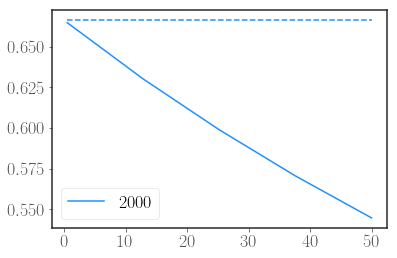

In [8]:
couplings = np.linspace(0.5,50,5)
#Omegas = np.array([ 40*1e-3, 80*1e-3, 120*1e-3])*ev_to_inv_cm
Omegas = [w0]
#Omegas = np.array([20e-3, 30e-3, 40e-3])*ev_to_inv_cm
#Omegas = np.array([100,200,300])
pop_ratios = []
pop_ratio_flat = []
i = 0
for w0 in Omegas:
    pop_ratio = []
    pop_ratio_fp = []
    for alpha in couplings:
        N=6
        PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                          silent=True, exc_diff=0)
        #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
        #H, phonon_operators, A_EM, PARAMS = get_H(PARAMS)
        #energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
        #energies_P, states_P, eta_P = polaron_eigenstates(PARAMS)
        #Ed_num.append(energies_dict['dark'][0])
        #Eb_num.append(energies_dict['bright'][0])
        #Ed_an.append(energies_P[0])
        #Eb_an.append(energies_P[1])
        pop_ratio.append( population_ratio_numerical(PARAMS) )
        pop_ratio_fp.append( population_ratio_numerical_Redfield(PARAMS) )
        print(alpha)
        #pop_ratio_fp.append(population_ratio_fast_phonon(PARAMS))
    pop_ratios.append(pop_ratio)    
    pop_ratio_flat.append(pop_ratio_fp) 
    plt.plot(couplings, pop_ratio, label=str(int(w0)), color=colours[i])
    plt.plot(couplings, pop_ratio_fp, ls = 'dashed', color=colours[i])
    i+=1
    #axes[1].plot(couplings, pop_ratio_fp, label=str(int(w0)))
    plt.legend()
"""plt.plot(couplings, Ed_num, label='numerical')
plt.plot(couplings, Ed_an)
plt.legend()
plt.figure()
plt.plot(couplings, Eb_num, label='numerical')
plt.plot(couplings, Eb_an)
plt.legend()
plt.figure()
plt.plot(couplings, np.array(Eb_num)-np.array(Ed_num), label='numerical')
plt.plot(couplings, np.array(Eb_an)-np.array(Ed_an))
plt.legend()
plt.figure()"""
#numerical_data = load_obj("DATA/population_ratio_comparison_NUM")
#data_241 = load_obj("DATA/Gamma_w0_dep/3ls_241")
#plt.plot(couplings, population_ratio_from_SS(numerical_data[0]), ls='dashed')

In [158]:
def population_ratio_from_SS(data_dict):
    PARAMS = data_dict['PARAMS']
    ops = make_expectation_operators(PARAMS)
    pd = np.array([i.tr() for i in data_dict['rho_add']*ops['dark']])
    pb = np.array([i.tr() for i in data_dict['rho_add']*ops['bright']])
    pg = np.array([i.tr() for i in data_dict['rho_add']*ops['OO']])
    return ((pd)/pg).real


dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])
dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])
dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])


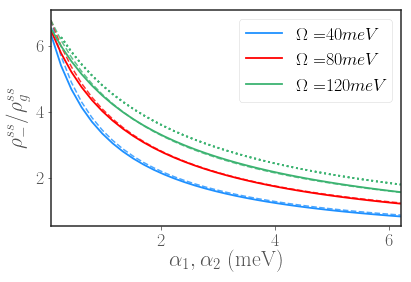

In [48]:
couplings = np.linspace(0.0,50,35)
SS_numerical_data = load_obj("DATA/population_ratio_comparison_50K")
#Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
colours = ['#1E90FF', '#FF0000', '#3CB371', '#FFA500']
def plot_population_ratio(data_dict, numerical,j, label='0'):
    x_values = 1000*data_dict['phonons']/ev_to_inv_cm
    PARAMS = data_dict['PARAMS']
    print(data_dict.keys())
    ops = make_expectation_operators(PARAMS)
    pd = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['dark']])
    pb = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['bright']])
    pg = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['OO']])
    #plt.plot(pd, label='DS')
    #plt.plot(pg, label='GS')
    #plt.legend()
    #plt.figure()
    plt.plot(x_values, ((pd)/pg).real, label=label, color=colours[j], linewidth=1.8)
    plt.plot(x_values, numerical, ls='dashed', color=colours[j], alpha=0.8)
    
    plt.ylabel(r"$\rho_{-}^{ss}/\rho_{g}^{ss}$")
    plt.xlabel(r"$\alpha_1, \alpha_2$ (meV)")
    plt.xlim(x_values[0],x_values[-1])
    plt.legend()
    

i = 0
for w0, data in zip(Omegas, SS_numerical_data):
    x_values = 1000*data['phonons']/ev_to_inv_cm
    w0_label = int(1000*w0/ev_to_inv_cm)
    plot_population_ratio(data, pop_ratios[i], i, label=r"$\Omega=$"+str(int(w0_label))+r"$meV$")
    plt.plot(x_values, pop_ratio_flat[2], ls='dotted', color=colours[2], alpha=1, linewidth=1.8)
    plt.subplots_adjust(left=0.14, bottom=0.2, right=0.95, top=0.95, wspace=0.25, hspace=0.08)
    #plt.savefig("PLOTS/PAPER/LaserComparison_LowerT.pdf")
    i+=1

# Higher T

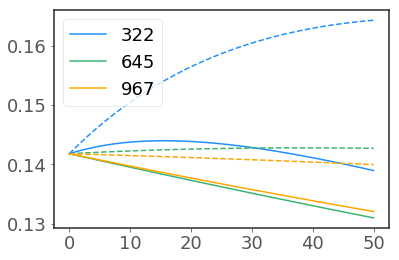

In [26]:
N=7

T_ph = 300.
w_2 = 1.4*ev_to_inv_cm
bias = 0 #10e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
Gamma = 100

couplings = np.linspace(0.0,50,35)
Omegas = np.array([ 40*1e-3, 80*1e-3, 120*1e-3])*ev_to_inv_cm
#Omegas = np.array([20e-3, 30e-3, 40e-3])*ev_to_inv_cm
#Omegas = np.array([100,200,300])
pop_ratios = []
pop_ratio_flat = []
i = 0
for w0 in Omegas:
    pop_ratio = []
    pop_ratio_fp = []
    for alpha in couplings:
        PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                          silent=True, exc_diff=0)

        pop_ratio.append( population_ratio_numerical(PARAMS) )
        pop_ratio_fp.append( population_ratio_numerical_flat_phonon(PARAMS) )
        #pop_ratio_fp.append(population_ratio_fast_phonon(PARAMS))
    pop_ratios.append(pop_ratio)    
    pop_ratio_flat.append(pop_ratio_fp) 
    plt.plot(couplings, pop_ratio, label=str(int(w0)), color=colours[i])
    plt.plot(couplings, pop_ratio_fp, ls = 'dashed', color=colours[i])
    i+=1
    #axes[1].plot(couplings, pop_ratio_fp, label=str(int(w0)))
    plt.legend()

dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])
dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])
dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])


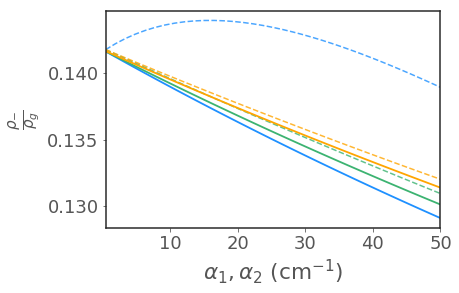

In [27]:
SS_numerical_data = load_obj("DATA/population_ratio_comparison_300K")
#Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
colours = ['#1E90FF', '#3CB371', '#FFA500']
def plot_population_ratio(data_dict, numerical, j, label='0'):
    PARAMS = data_dict['PARAMS']
    print(data_dict.keys())
    ops = make_expectation_operators(PARAMS)
    pd = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['dark']])
    pb = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['bright']])
    pg = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['OO']])
    #plt.plot(pd, label='DS')
    #plt.plot(pg, label='GS')
    #plt.legend()
    #plt.figure()
    plt.plot(data_dict['phonons'], ((pd)/pg).real, label=label, color=colours[j], linewidth=1.8)
    plt.plot(data_dict['phonons'], numerical, ls='dashed', color=colours[j], alpha=0.8)
    plt.ylabel(r"$\frac{\rho_{-}}{\rho_{g}}$")
    plt.xlabel(r"$\alpha_1, \alpha_2$ (cm$^{-1})$")
    plt.xlim(0.5,50)
    #plt.legend()
    plt.savefig("PLOTS/PAPER/LaserComparisonNoLegend_300K.pdf")

i = 0
for w0, data in zip(Omegas, SS_numerical_data):
    plot_population_ratio(data, pop_ratios[i], i, label=r"$\Omega=$"+str(int(w0))+r"$cm^{-1}$")
    i+=1

# Overdamped

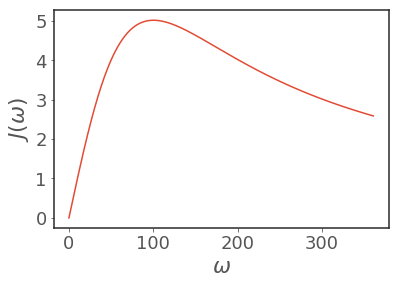

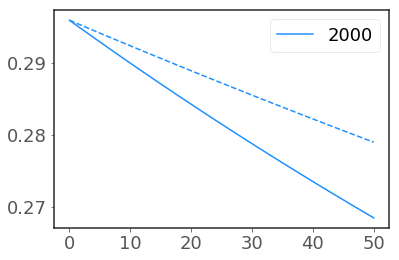

In [29]:
N=5
T_ph = 150.
w_2 = 1.4*ev_to_inv_cm
bias = 10e-3*ev_to_inv_cm #0.0000001*ev_to_inv_cm
V = 10e-3*ev_to_inv_cm #0.00001*ev_to_inv_cm
alpha = 1.
T_EM = 6000.
alpha_EM = 5.309e-3 # inv_ps_to_inv_cm *10^-3
w0 = 2000. # 
Gamma = (w0**2)/100
eta = gap(bias, V)
plot_UD_SD(Gamma, 10, w0, eps=2*eta)

couplings = np.linspace(0.0,50,45)
#Omegas = np.array([ 40*1e-3, 80*1e-3, 120*1e-3])*ev_to_inv_cm
#Omegas = np.array([20e-3, 30e-3, 40e-3])*ev_to_inv_cm
#Omegas = np.array([100,200,300])
pop_ratios = []
pop_ratio_flat = []
i = 0

pop_ratio = []
pop_ratio_fp = []
for alpha in couplings:
    PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                      V = V, alpha=alpha,
                      T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                      num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                      silent=True, exc_diff=0)

    pop_ratio.append( population_ratio_numerical(PARAMS) )
    pop_ratio_fp.append( population_ratio_numerical_flat_phonon(PARAMS) )
    #pop_ratio_fp.append(population_ratio_fast_phonon(PARAMS))
pop_ratios.append(pop_ratio)    
pop_ratio_flat.append(pop_ratio_fp)
plt.plot(couplings, pop_ratio, label=str(int(w0)), color=colours[i])
plt.plot(couplings, pop_ratio_fp, ls = 'dashed', color=colours[i])
i+=1
#axes[1].plot(couplings, pop_ratio_fp, label=str(int(w0)))
plt.legend()




dict_keys(['rho_nonadd', 'rho_add', 'rho_wc', 'op_list', 'phonons', 'PARAMS'])


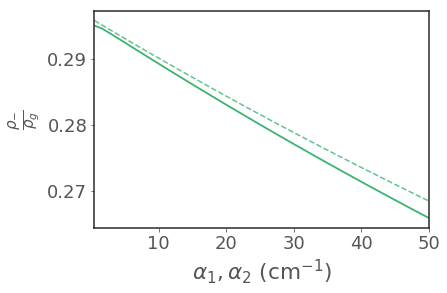

In [30]:
SS_numerical_data = load_obj("DATA/population_ratio_comparison_overdamped")
#Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
colours = ['#1E90FF', '#3CB371', '#FFA500']
def plot_population_ratio(data_dict, numerical, j, label='0'):
    PARAMS = data_dict['PARAMS']
    print(data_dict.keys())
    ops = make_expectation_operators(PARAMS)
    pd = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['dark']])
    pb = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['bright']])
    pg = np.array([i.tr() for i in data_dict['rho_nonadd']*ops['OO']])
    
    plt.plot(data_dict['phonons'], ((pd)/pg).real, label=label, color=colours[j], linewidth=1.8)
    plt.plot(data_dict['phonons'], numerical, ls='dashed', color=colours[j], alpha=0.8)
    plt.ylabel(r"$\frac{\rho_{-}}{\rho_{g}}$")
    plt.xlabel(r"$\alpha_1, \alpha_2$ (cm$^{-1})$")
    plt.xlim(0.5,50)
    #plt.legend()
    plt.savefig("PLOTS/PAPER/LaserComparisonNoLegend_overdamped.pdf")


plot_population_ratio(SS_numerical_data, pop_ratios[0], i, label=r"$\Omega=$"+str(int(w0))+r"$cm^{-1}$")


In [ ]:
# For weaker V, calculate matching system steadystates from ME



# Displacements
Defining everything via the IBM hamiltonian and taking into account the normalisation of the displacement operator gives the right answers for this known test case. However, with RC mapping parameters and spectral densities taken from the [J. Chem. Phys paper](https://aip.scitation.org/doi/10.1063/1.4940218) and the Liouvillians defined in my code/notes, which agree with Redfield without any hacky prefactors, it appears like $\alpha_{ph}$ is missing a factor of 4 (or $\kappa$ is missing a factor of 2). This gives a factor of 2 error in the displacment of the modes. I think my approach now will be to include a factor of $1/2$ in the definition of the displacement, so that the re. I'll fully resolve this issue later on.

In [5]:
def plot_decay_rates(data_dict, couplings):
    for w0, dat in data_dict.items(): # for each w0, unpack data which is dictionary with keys [btd, dtg, btg]
        # for each set of rates, plot a new figure
        displacements = [c/float(w0) for c in couplings] 
        for rate_type, rate_data in dat.items(): # for each set of rates, plot each
            plt.figure()
            plt.title(rate_type +' '+ w0)
            for label, data_set in rate_data.items():
                if (rate_type != 'btd') and (label == 'wc'):
                    data_set = np.array(data_set)
                if (label != 'wc'):
                    plt.plot(displacements, data_set, label=label)
            plt.legend()

# Low Temperature characterisation

In the first instance, I need to understand what happens at low phonon and EMF temperature. Just choose some sensible parameters (say from monomer paper or Dominic's dimer paper) and calculate. $\omega_0 = 30meV, 60meV, 120meV$
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$ Does increasing phonon coupling actually increase population of dark state? Is this because $\sigma_x$ gains displacement operators?
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

Then I'll be in a position to understand EMF thermal occupation. Steadystate population is likely to be $\propto\Gamma_{g,+}/\Gamma_{-,0}$, unless dominated by phonon reorganisation.
- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

Can I then characterise population by $\Gamma_{g,+}/\Gamma_{-,0}$? In the first instance just from zero states to manifolds.

In [7]:
def displace(offset, a):
    return (offset*(a.dag())/sqrt(2) - offset.conjugate()*a/sqrt(2)).expm()

def undisplaced_initial(init_sys, PARAMS):
    n1 = Occupation(PARAMS['w0_1'], PARAMS['T_1'])
    n2 = Occupation(PARAMS['w0_2'], PARAMS['T_2'])
    return tensor(init_sys, qt.enr_thermal_dm([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'], 
                                              [n1, n2]))
def position_ops(PARAMS):
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    return [tensor(I_sys, (a + a.dag())/sqrt(2)) for a, omega in zip(atemp, [PARAMS['w0_1'], PARAMS['w0_2']])]


def offsets(init_sys, PARAMS):
    energies, states = exciton_states(PARAMS)
    normal_disp_1 = sqrt(pi*PARAMS['alpha_1']/(2*PARAMS['w0_1']))
    normal_disp_2 = sqrt(pi*PARAMS['alpha_2']/(2*PARAMS['w0_2']))
    eta = sqrt(PARAMS['bias']+4*PARAMS['V'])
    coeff_p = (eta + PARAMS['bias'])/(2*eta)
    coeff_m = (eta - PARAMS['bias'])/(2*eta)
    if init_sys == 'dark':
        return states[0], normal_disp_1*coeff_m, normal_disp_2*coeff_p
    elif init_sys == 'bright':
        return states[1], normal_disp_1*coeff_p, normal_disp_2*coeff_m
    elif init_sys == 'ground':
        return OO, 0, 0
    else:
        raise KeyError("Please choose dark, bright or ground")

def displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False):
    init_state, offset_1, offset_2 = offsets(init_sys, PARAMS)
    atemp = enr_destroy([PARAMS['N_1'], PARAMS['N_2']], PARAMS['exc'])
    x = position_ops(PARAMS)
    r0 = undisplaced_initial(init_state*init_state.dag(), PARAMS)
    disp = copy.deepcopy(r0)
    for offset, a_ in zip([offset_1, offset_2], atemp):
        d = tensor(I_sys, displace(offset, a_))
        disp =  d * disp * d.dag()
    try:
        error = 100*(abs((disp*x[0]).tr()- offset_1)/offset_1 + abs((disp*x[1]).tr()- offset_2)/offset_2)
        if error>0.5:
            print ("Error in displacement: {:0.8f}%. Predicted {:0.4f} , actual {:0.4f}".format(error, offset_1, (disp*x[0]).tr()))
            print ("Ratio of kBT to Omega: {:0.4f}".format(0.695*PARAMS['T_1']/PARAMS['w0_1']))
            if ((PARAMS['T_1'] != PARAMS['T_2']) or (PARAMS['w0_1'] != PARAMS['w0_2'])):
               print("Ratio of kBT to Omega (2): {:0.4f}".format(0.695*PARAMS['T_2']/PARAMS['w0_2']))
        if return_error:   
            return disp, error
        else:
            return disp
    except:
        return disp

def thermal_manifold(energies_dict, states_dict, T, manifold='bright'):

    if manifold == 'both':
        states = list(states_dict['bright']) + list(states_dict['dark'])
        energies = list(energies_dict['bright']) + list(energies_dict['bright'])
    else:
        states = states_dict[manifold]
        energies = energies_dict[manifold]
    thermal_unnormalised = (-beta_f(T)*sum([E*K*K.dag() for E, K in zip(energies, states)])).expm()
    return thermal_unnormalised/thermal_unnormalised.tr()


In [223]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0 # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 100e-3 * ev_to_inv_cm
T_EM = 6000.
T_ph = 77.
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 800. #2*w0
w0 = 30e-3*ev_to_inv_cm
print (eta, V/eta)
N=4

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
thermal_manifold(energies_dict, states_dict, T_ph, manifold='bright')

161.31 0.5


In [8]:
def plot_manifold_rates(data_dict, title = 'dtg', show_total_decay=False):
    couplings =data_dict['couplings']
    for omega_0, data in data_dict.items():
        if omega_0 == 'couplings':
            couplings = data
        else:
            plt.figure()
            plt.title(title+ ' ' + omega_0)
            i=0
            for rate_name, rate_data in data.items():
                if(  (abs(sum(rate_data['nonadd'])) <1e-9)):
                    pass # we don't really want the total decay rate in there, or any that are zero
                else:
                    c = colourWheel[i]
                    plt.plot(couplings, rate_data['nonadd'], linestyle='solid', label=rate_name, c=c) 
                    plt.plot(couplings, rate_data['add'], linestyle='dashed', c=c)
                    i+=1
            plt.legend()

In [28]:
def thermal_to_states(bias, V, Gamma, T_ph, w_2=1.1e4, alpha_EM=1., T_EM=0.,
                         N=5, start_manifold='dark', end_manifold='OO'):
    # Characterise low T_ph behaviour of decay
    eta = sqrt(bias**2 + 4*V**2)
    Omegas = np.array([ 30e-3, 60e-3, 120e-3])*ev_to_inv_cm
    couplings = np.linspace(0.1,50,20)
    data_names = ["{}".format(int(i)) for i in Omegas]
    in_in_dict = {'nonadd':[], 'add': []}
    state_indexes = [0,0,1,2,3,4,5]
    data_dict = {}
    #                   'btd': copy.deepcopy(in_in_dict)} for key in data_names}
    i = 0
    for w_0 in Omegas:
        inner_data_dict = {'st-manifold': copy.deepcopy(in_in_dict),
                'st-ft': copy.deepcopy(in_in_dict)}
        for alpha in couplings:
            #N=3
            PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w_0,
                              silent=True, exc_diff=N)
            #PARAMS = get_converged_N(PARAMS, err_threshold=0.5, max_N=12, exc_diff_N=True) # Turn ENR off
            H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
            energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
            ops = make_expectation_operators(PARAMS)
            #ri = displaced_initial(PARAMS, init_sys=start_manifold, silent=False, return_error=False)
            ri = thermal_manifold(energies_dict, states_dict, T_ph, manifold=start_manifold)
            LVN  = -1j*(qt.spre(H[1]) - qt.spost(H[1]))
            for idx, state_label in zip(state_indexes, inner_data_dict.keys()):
                if state_label == 'st-manifold': # Can check decay to whole target manifold
                    inner_data_dict[state_label]['nonadd'].append(rate_to_manifold(ri, LVN+L['nonadd'], 
                                                                             ops, manifold=end_manifold))
                    inner_data_dict[state_label]['add'].append(rate_to_manifold(ri, LVN+L['add'],
                                                                             ops, manifold=end_manifold))
                else:
                    rf = thermal_manifold(energies_dict, states_dict, T_ph, manifold=end_manifold)
                    inner_data_dict[state_label]['nonadd'].append(rate_to_state(ri, rf, LVN+L['nonadd']))
                    inner_data_dict[state_label]['add'].append(rate_to_state(ri, rf, LVN+L['add']))
            i+=1
            if i%10 == 0:
                print (i)
        data_dict.update({str(int(w_0)) : inner_data_dict})
    print("Calculation complete")
    data_dict.update({'couplings' : couplings})
    return data_dict

In [29]:
w_2 = 1.4 * ev_to_inv_cm
bias = 0 # 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 6000.
T_ph = 77.
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 800. #2*w0
w0 = 30e-3*ev_to_inv_cm
print (eta, V/eta)
N=5

161.31 0.5


In [19]:
PARAMS = PARAMS_setup(bias=30, w_2=w_2, 
                          V = V, alpha=alpha,
                          T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                          num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                          silent=True, exc_diff=0)
def sites(PARAMS):
    eta = gap(PARAMS['bias'],PARAMS['V'])
    energies, states = exciton_states(PARAMS)
    d,b = states[0], states[1]
    site_1 = 0.5*((eta+PARAMS['bias'])*b*b.dag() + 2*PARAMS['V']*(b*d.dag()+d*b.dag())+(eta-PARAMS['bias'])*d*d.dag())/eta
    site_2 = 0.5*((eta-PARAMS['bias'])*b*b.dag() - 2*PARAMS['V']*(b*d.dag()+d*b.dag())+(eta+PARAMS['bias'])*d*d.dag())/eta
    sigma_x = 0.5*(4*PARAMS['V']*(b*b.dag()-d*d.dag()) - 2*PARAMS['bias']*(b*d.dag()+d*b.dag()))/eta
    print(site_1, site_2, sigma_x)
sites(PARAMS)

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 1. 0.]
 [0. 0. 0.]] Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 1.]] Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [201]:
def rate_to_manifold(init_rho, Liouv, ops, ):
    rho_dot = qt.vector_to_operator(Liouv*qt.operator_to_vector(init_rho))
    return (rho_dot*ops).ptrace(0)

PARAMS = PARAMS_setup(bias=bias, w_2=w_2, 
                              V = V, alpha=alpha,
                              T_EM=T_EM, T_ph=T_ph, alpha_EM=alpha_EM, shift=True,
                              num_cpus=4, N=N, Gamma=Gamma, w_0=w0,
                              silent=True, exc_diff=N)
H, L, PARAMS = get_H_and_L(PARAMS, silent=True, threshold=0., shift_in_additive=False)
energies_dict, states_dict, phonon_occ_dict = separate_states(H[1], PARAMS, trunc=0.8)
ops = make_expectation_operators(PARAMS)
LVN  = -1j*(qt.spre(H[1]) - qt.spost(H[1]))
L_ = L['add']+LVN
#ri = states_dict['bright'][0] #displaced_initial(PARAMS, init_sys=start_manifold, silent=False, return_error=False)
ri = displaced_initial(PARAMS, init_sys='bright', silent=False, return_error=False)
rf = displaced_initial(PARAMS, init_sys='dark', silent=False, return_error=False)

rate_E = rate_to_state(ri, rf, L_)

Error in displacement: 0.77435476%. Predicted 1.1441 , actual 1.1397
Ratio of kBT to Omega: 0.2212
Error in displacement: 0.77435476%. Predicted 1.1441 , actual 1.1397
Ratio of kBT to Omega: 0.2212


In [202]:
print (rate_E)
energies, states = exciton_states(PARAMS)
(states[0]*states[0].dag())*rate_E

(5.647869324998389e-14+2.3915331520685257e-15j)


Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

In [30]:

dark_ground_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
ground_dark_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='dark')

10
20
30
40
50
60
Calculation complete
10
20
30
40
50
60
Calculation complete


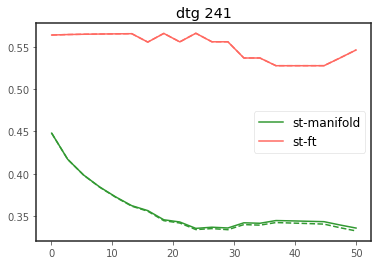

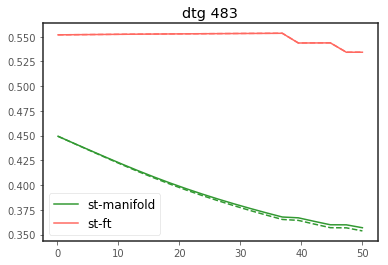

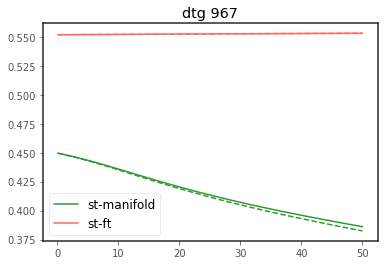

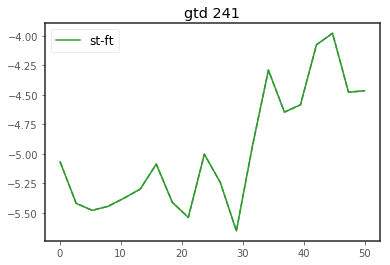

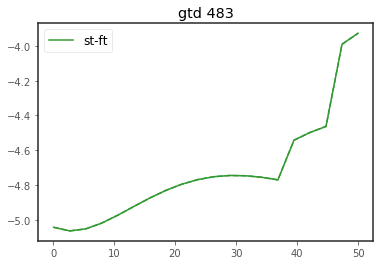

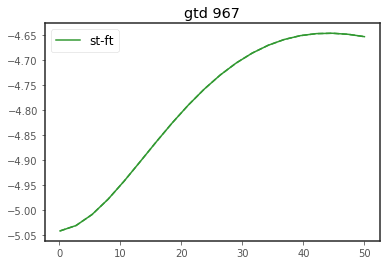

In [31]:
plot_manifold_rates(dark_ground_high_T, title='dtg')
plot_manifold_rates(ground_dark_high_T, title='gtd')

In [32]:
bright_ground_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')
ground_bright_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')

10
20
30
40
50
60
Calculation complete
10
20
30
40
50
60
Calculation complete


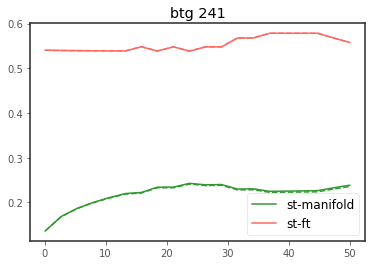

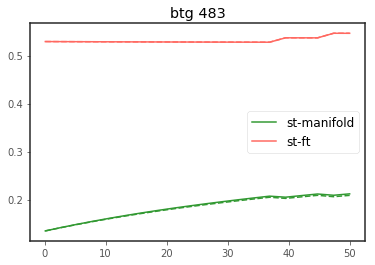

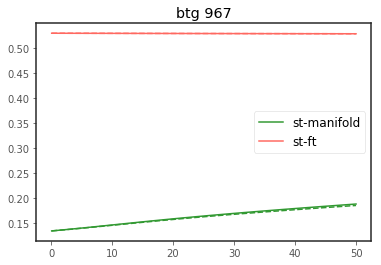

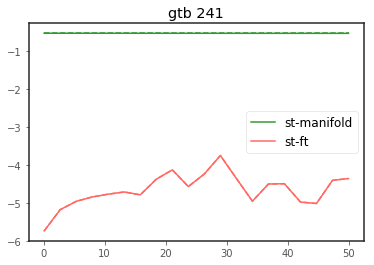

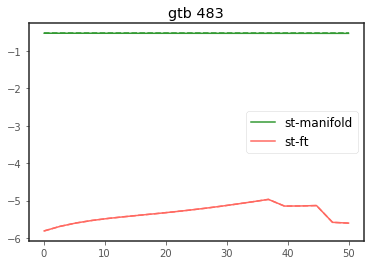

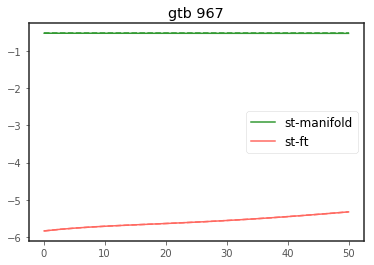

In [33]:
plot_manifold_rates(bright_ground_high_T, title='btg')
plot_manifold_rates(ground_bright_high_T, title='gtb')

In [34]:
bright_dark_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
dark_bright_high_T = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='bright')


10
20
30
40
50
60
Calculation complete
10
20
30
40
50
60
Calculation complete


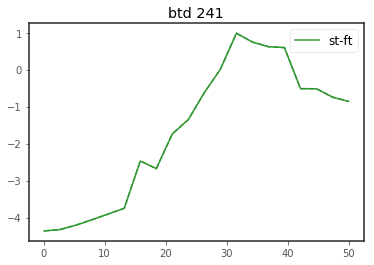

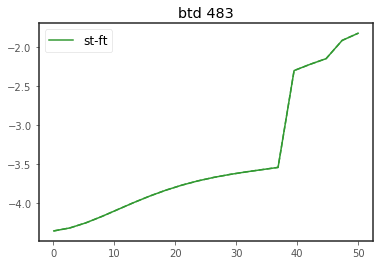

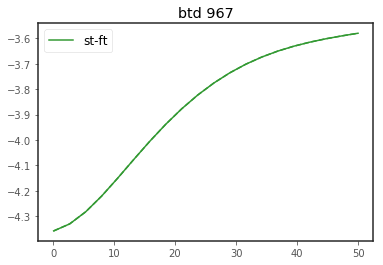

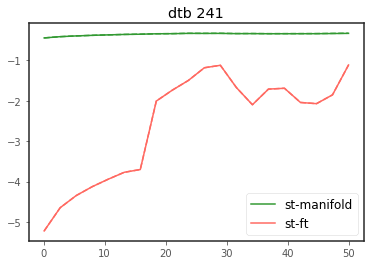

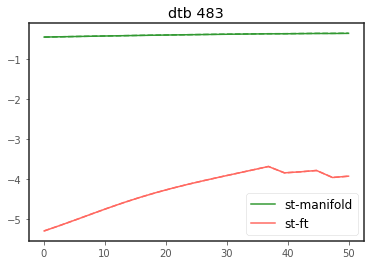

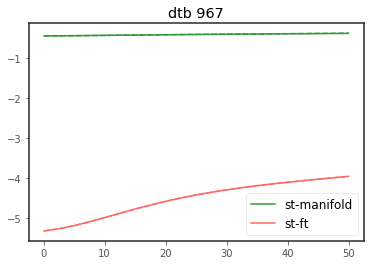

In [35]:
plot_manifold_rates(bright_dark_high_T, title='btd')
plot_manifold_rates(dark_bright_high_T, title='dtb')

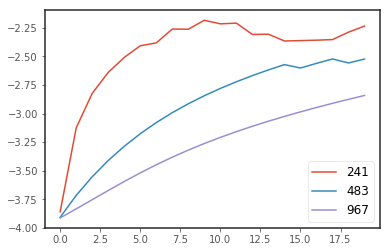

In [48]:
w0_mag = '483'
def fast_bd_population_ratio(gd, gb, dg, db, bg, bd):
    return (gd + gb)/bg

def full_population_ratio(gd, gb, dg, db, bg, bd):
    A = dg + db*(1- (bd/(bd+bg)))
    return gd/A + (bd*gb)/(A*(bd+bg))


for w0_mag in ['241', '483', '967']:
    state = 'st-ft'
    bg_rate = np.array(bright_ground_high_T[w0_mag]['st-manifold']['add'])
    gb_rate = np.array(ground_bright_high_T[w0_mag]['st-manifold']['add'])
    gd_rate = np.array(ground_dark_high_T[w0_mag]['st-manifold']['add'])
    dg_rate = np.array(dark_ground_high_T[w0_mag]['st-manifold']['add'])
    db_rate = np.array(dark_bright_high_T[w0_mag]['st-manifold']['add'])
    bd_rate = np.array(bright_dark_high_T[w0_mag]['st-manifold']['add'])
    #for i in range(5):
    #    db_rate += np.array(dark_bright_high_T[w0_mag]['st-f'+str(i)]['add'])
    #    bd_rate += np.array(bright_dark_high_T[w0_mag]['st-f'+str(i)]['add'])
    #print ((gb_rate+gd_rate)/dg_rate)
    #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
    plt.plot(fast_bd_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), label=w0_mag)
    plt.legend()


$|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=0$

$|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=0$

- These rates suggest that the zero phonon transition is the largest between bright and dark.
- The $|\psi_+^{0}\rangle \to |-\rangle$ rate is predicted to be zero, which doesn't make sense. I can't work out why this would be the case, unless it's do with with product state thing again.
- Strangely, increasing $\omega_0$ decreases the bright-to-dark rate. This is exactly the same in both non-additive and additive cases. 

When $\omega_0$ increases, the overlap between ground and exciton states increases due to smaller displacement. This might cause the excitonic coupling to be smaller since these terms gain

$|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=0$ 

# Thermal Occupation of EMF

- $|\psi_-^{0}\rangle \to |g^{n}\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |\psi_-\rangle$ decay rates at $T_{EM}=6000$
- $|\psi_+^{0}\rangle \to |g\rangle$ decay rates at $T_{EM}=6000$

In [125]:
w_2 = 1.4 * ev_to_inv_cm
bias = 10e-3 * ev_to_inv_cm
V = 10e-3 * ev_to_inv_cm
alpha = 1e-3 * ev_to_inv_cm
T_EM = 0.
T_ph = 150
alpha_EM = 1e-2*inv_ps_to_inv_cm
eta = gap(bias, V)
#w0 = 1.2*eta# 18e-3*ev_to_inv_cm
Gamma = 80. #2*w0
print (eta, V/eta)

180.35006272524555 0.4472135954999579


In [126]:
dark_ground_ = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='dark', end_manifold='ground')
ground_dark_ = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=N, T_EM=6000,
                                                      start_manifold='ground', end_manifold='dark')

10
20
Error in displacement: 0.55206940%. Predicted -0.5497 , actual -0.5488
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.60811059%. Predicted -0.5633 , actual -0.5623
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.66749169%. Predicted -0.5765 , actual -0.5754
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.73028915%. Predicted -0.5894 , actual -0.5882
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.79657754%. Predicted -0.6020 , actual -0.6007
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.86642953%. Predicted -0.6143 , actual -0.6130
Ratio of kBT to Omega: 0.4308
Error in displacement: 0.93991585%. Predicted -0.6265 , actual -0.6250
Ratio of kBT to Omega: 0.4308
Error in displacement: 1.01710526%. Predicted -0.6383 , actual -0.6368
Ratio of kBT to Omega: 0.4308
Error in displacement: 1.09806452%. Predicted -0.6500 , actual -0.6484
Ratio of kBT to Omega: 0.4308
Error in displacement: 1.18285835%. Predicted -0.6615 , actual -0.6597
Ratio of kBT t

KeyboardInterrupt: 

In [77]:
ground_dark_

{'241': {'st-manifold': {'nonadd': [0.0036370799304901347,
    0.0036361225941570793,
    0.0036351654808529474,
    0.0036342085913821176,
    0.0036332519247738028,
    0.0036322954818549034,
    0.0036313392619572345,
    0.0036303832654682898,
    0.0036294274921595503,
    0.0036284719414502523,
    0.003627516614643467,
    0.003626561510421563,
    0.003625606629621769,
    0.003624651971431415,
    0.003623697537292615,
    0.0036227433253801507,
    0.0036217893358830747,
    0.0036208355693663563,
    0.003619882025790894,
    0.0036189287048214677,
    0.0036179756065891342,
    0.0036170227307864185,
    0.003616070077579817,
    0.003615117647136695,
    0.003614165440034941,
    0.0036132134549289163,
    0.003612261691885424,
    0.0036113101519156497,
    0.0036103588341880647,
    0.0036094077380795938,
    0.0036084568650251955,
    0.003607506213154435,
    0.003606555784341981,
    0.0036056055777374924,
    0.003604655592581076,
    0.003603705830277211,
    0.0036

In [ ]:
plot_manifold_rates(dark_ground_, title='dtg')
plot_manifold_rates(ground_dark_, title='gtd')

In [ ]:
w0_mag = '483'
def full_population_ratio(gd, gb, dg, db, bg, bd):
    A = dg + db*(1- (bd/(bd+bg)))
    return gd/A + (bd*gb)/(A*(bd+bg))

for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground[w0_mag]['st-manifold']['nonadd'])
    gb_rate = np.array(ground_bright[w0_mag]['st-manifold']['nonadd'])
    gd_rate = np.array(ground_dark_[w0_mag]['st-manifold']['nonadd'])
    dg_rate = np.array(dark_ground_[w0_mag]['st-manifold']['nonadd'])
    
    db_rate = np.array(dark_bright_high[w0_mag]['st-f0']['nonadd'])
    bd_rate = np.array(bright_dark_high[w0_mag]['st-f0']['nonadd'])
    #print ((gb_rate+gd_rate)/dg_rate)
    #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), )
    plt.legend()

In [74]:
bright_ground = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='bright', end_manifold='ground')
ground_bright = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='ground', end_manifold='bright')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


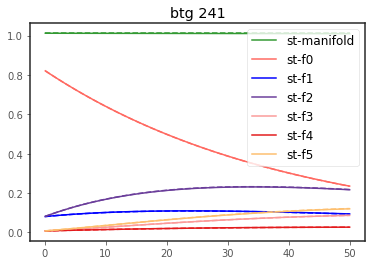

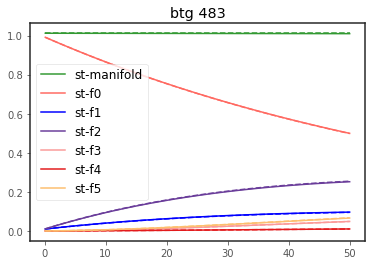

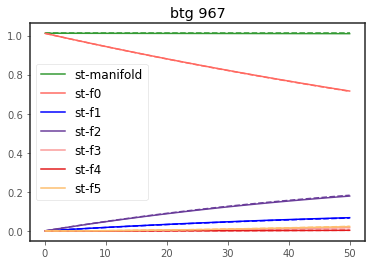

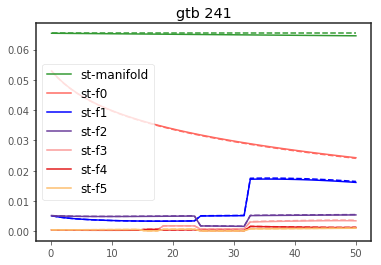

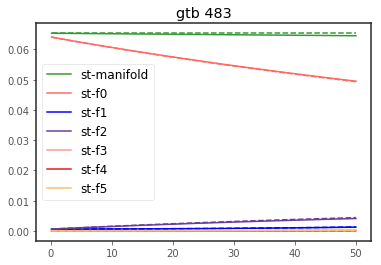

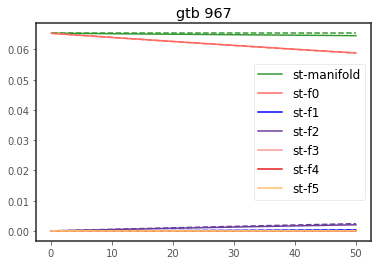

In [75]:
plot_manifold_rates(bright_ground, title='btg')
plot_manifold_rates(ground_bright, title='gtb')

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
Calculation complete


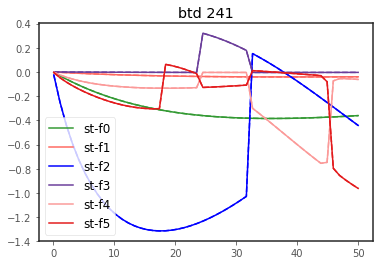

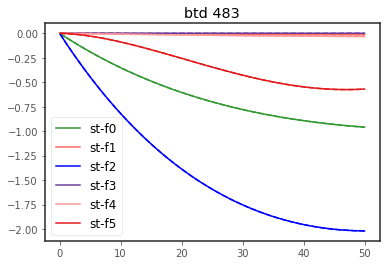

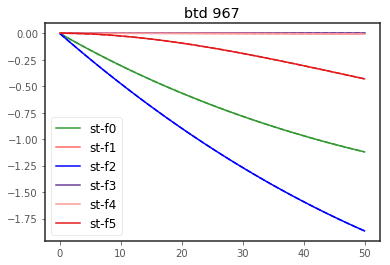

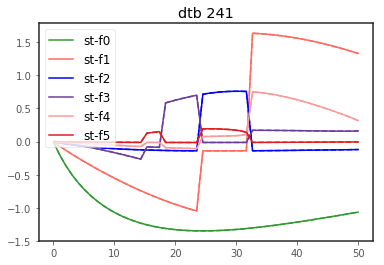

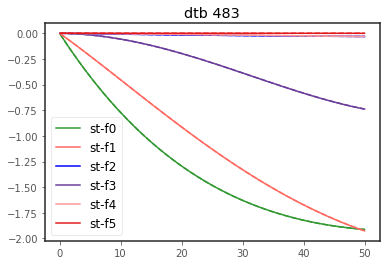

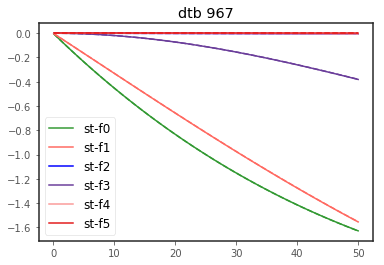

In [76]:
bright_dark_high = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='bright', end_manifold='dark')
dark_bright_high = thermal_to_states(bias, V, Gamma, T_ph, w_2=w_2, alpha_EM=1., N=7, T_EM=6000,
                                                      start_manifold='dark', end_manifold='bright')
plot_manifold_rates(bright_dark_high, title='btd')
plot_manifold_rates(dark_bright_high, title='dtb')

$\Gamma_{+,g}$ is not a function of optical field temperature, but $\Gamma_{g,+}$ is.

# $\Gamma_{g,+}/\Gamma_{-,0}$

In [153]:
def pressure_rate(bright_up, bright_down, 
                  dark_up, dark_down, add_type='nonadd'):
    num = np.array(bright_up[add_type])+np.array(dark_up[add_type])
    print (np.array(dark_down[add_type]))
    return num/(np.array(dark_down[add_type]))

def plot_population_pressure(ground_bright, bright_ground, ground_dark, dark_ground):
    # Should be for high EMF temperature
    couplings =ground_bright['couplings']
    plt.figure()
    plt.title(r"$\Gamma_{g,+}/\Gamma_{-,g}$")
    for i, omega_0 in enumerate(ground_bright.keys()):
        if omega_0 == 'couplings':
            pass
        else:
            (bright_up, bright_down, dark_up, dark_down) = (ground_bright[omega_0]['s0-f0'], 
                                                                bright_ground[omega_0]['s0-f0'], 
                                                                ground_dark[omega_0]['s0-f0'], 
                                                                dark_ground[omega_0]['s0-f0'])
            
            #print ((gb_rate+gd_rate)/dg_rate)
            #plt.plot((gb_rate+gd_rate)/dg_rate, label=w0_mag)
            c = colourWheel[i]
            plt.plot(couplings, pressure_rate(bright_up, bright_down, 
                                              dark_up, dark_down, add_type='nonadd'), 
                     linestyle='solid', label=omega_0, c=c)
            plt.plot(couplings, pressure_rate(bright_up, bright_down, 
                                              dark_up, dark_down, add_type='add'), 
                     linestyle='dashed', c=c)
    plt.legend()

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]


/Users/admin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


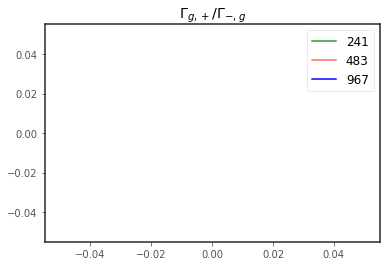

In [45]:
plot_population_pressure(ground_bright_high_T, bright_ground_high_T, ground_dark_high_T, dark_ground_high_T) 

This metric that I have made: the larger it is, the more highly populated the system should be at steadystate

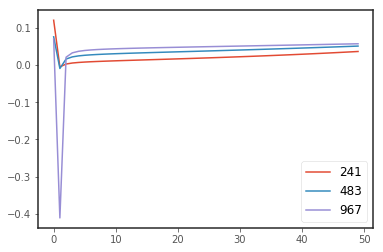

In [155]:
plt.figure()
for w0_mag in ['241', '483', '967']:
    bg_rate = np.array(bright_ground[w0_mag]['st-f0']['add'])
    gb_rate = np.array(ground_bright[w0_mag]['st-f0']['add'])
    gd_rate = np.array(ground_dark_[w0_mag]['st-f0']['add'])
    dg_rate = np.array(dark_ground_[w0_mag]['st-f0']['add'])

    db_rate = np.array(dark_bright_high[w0_mag]['st-f0']['add'])
    bd_rate = np.array(bright_dark_high[w0_mag]['st-f0']['add'])
    plt.plot(full_population_ratio(gd_rate, gb_rate, dg_rate, db_rate, bg_rate, bd_rate), label=w0_mag)
    plt.legend()